In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
from pathlib import Path
import time
import math
from typing import Union
import os
import cv2
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt
import tree_segmentation as ts
from semantic_sam import semantic_sam_l
import torch_geometric as pyg
from tree_segmentation.extension import Mesh, ops_3d, utils
from tree_segmentation import Tree2D, Tree3Dv2, Tree3D
from tree_segmentation.render import choose_best_views, random_camera_position
from paper.paper_util import get_2d_tree_from_3d
from evaluation.eval_Replica import load_mesh_and_gt
import open3d as o3d


/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device('cuda')
torch.set_grad_enabled(False)
glctx = dr.RasterizeCudaContext()

2.0.0+cu117


In [3]:
data_root = Path('~/data/Replica').expanduser()
data_dir = data_root.joinpath('room_1')
print('data direcotry:', data_dir)
mesh_path = data_dir.joinpath('mesh.ply')
cache_dir = Path(f'./results/{ts.get_hash_name(mesh_path)}')
cache_dir.mkdir(exist_ok=True)
print('cache dir:', cache_dir)

data direcotry: /home/wan/data/Replica/room_1
cache dir: results/Replica_room_1_mesh


In [6]:
cache_file = cache_dir.joinpath(mesh_path.name).with_suffix('.mesh_cache')
if cache_file.exists() and 0:
    mesh = torch.load(cache_file, map_location=device)  # type: Mesh
    gt = Tree3Dv2(mesh, device=devie)
    gt.load(cache_dir.jointpath('gt.tree3dv2'))
else:
    mesh, gt = load_mesh_and_gt(data_dir, cache_dir, force=True)
    mesh = mesh.cuda().unit_size()
    torch.save(mesh, cache_file)
    print('save cached mesh to', cache_file)
print(mesh)
print(mesh.AABB)
mesh.v_pos = ops_3d.xfm(mesh.v_pos, ops_3d.rotate_z(-math.radians(25), device))[:, :3].contiguous()
mesh.v_pos = mesh.v_pos[:, (0, 2, 1)].contiguous()
mesh = mesh.unit_size()
print(mesh.AABB)

numpy((645436, 3), float64), numpy((1290156, 3), int64)


/home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


[Tree3D] Save results to results/Replica_room_1_mesh/gt.tree3dv2
save cached mesh to results/Replica_room_1_mesh/mesh.mesh_cache
Mesh(vertices=250295, faces=499920, clr, nrm)
tensor([[-1.0000, -0.8618, -0.4142],
        [ 1.0000,  0.8618,  0.4142]], device='cuda:0')
tensor([[-1.0000, -0.4496, -0.5724],
        [ 1.0000,  0.4496,  0.5724]], device='cuda:0')


# GT Semantic Segmentation

# 2D Rendering and Segmentation

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  4.3711e-08,  0.0000e+00],
        [ 0.0000e+00, -4.3711e-08,  1.0000e+00, -2.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


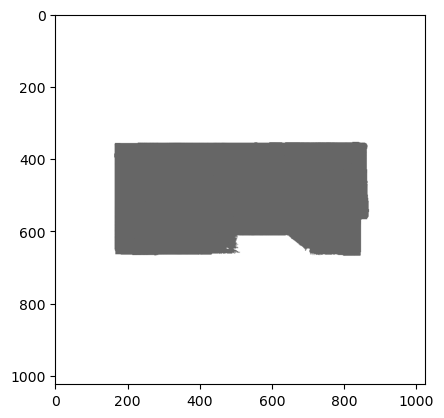

In [8]:
fovy = math.radians(90)
image_size = 1024
Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size)).to(device)
# Tw2v = torch.eye(4, device=device)
Tw2v= ops_3d.look_at(ops_3d.coord_spherical_to(2, 0.5*torch.pi, 0), torch.zeros(3)).to(device)
print(Tw2v)
image, tri_id = ts.render_mesh(glctx, mesh, Tw2v=Tw2v, fovy=fovy, image_size=image_size)
plt.imshow(image.cpu().numpy())

In [63]:
N = 100
if 0 and cache_dir.joinpath('Tw2v.pth').exists():
    Tw2vs = torch.load(cache_dir.joinpath('Tw2v.pth'), map_location=device)
    print('Load Tw2v from', cache_dir.joinpath('Tw2v.pth'))
else:
    print(mesh.AABB)
    view_box = torch.tensor([[-0.6, -0.2,-0.2], [0.6, 0.2, 0.2]], device=device)
    eye = random_camera_position(mesh, view_box, N=N * 10)
    print(eye.shape)

    phi_range = [0, math.pi * 2.]
    cos_theta_range = [math.cos(0.2 * math.pi), math.cos(math.pi * 0.8)]
    phis = torch.rand((eye.shape[0],), device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]
    thetas = torch.arccos(
        torch.rand((eye.shape[0],), device=device) * (cos_theta_range[1] - cos_theta_range[0]) + cos_theta_range[0])
    radius = torch.ones((eye.shape[0],), device=device)
    at = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
    Tw2vs = ops_3d.look_at(eye, eye + at)
    print(utils.show_shape(Tw2vs))

    N = min(N, len(Tw2vs))
    Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
    indices = choose_best_views(glctx, mesh, Tv2c @ Tw2vs, N)
    print(utils.show_shape(indices))
    Tw2vs = Tw2vs[indices]
    
    torch.save(Tw2vs, cache_dir.joinpath('Tw2v.pth'))
    print('Save Tw2v from', cache_dir.joinpath('Tw2v.pth'))
print('Tw2vs:', Tw2vs.shape)

tensor([[-1.0000, -0.4495, -0.5724],
        [ 1.0000,  0.4495,  0.5724]], device='cuda:0')
torch.Size([858, 3])
F32Tensor[858, 4, 4]
Best the average number of viewed faces: tensor(12.3725, device='cuda:0')
LongTensor[100]
Save Tw2v from results/3d0579debd6956160293c563a88270fd/Tw2v.pth
Tw2vs: torch.Size([100, 4, 4])


In [12]:
# min_max = mesh.AABB
# print('mesh bounding box:', min_max.tolist())
# min_max = min_max * 0.9
# min_distance = 0.05
# xyz = torch.rand((N, 3), device=device) * (min_max[1] - min_max[0]) + min_max[0]
# print(utils.show_shape(xyz), xyz.aminmax(dim=0))

# N = 100
# phi_range = [0, math.pi * 2.]
# cos_theta_range = [math.cos(0), math.cos(math.pi)]
# phis = torch.rand((N,), device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]
# thetas = torch.arccos(torch.rand((N,), device=device) * (cos_theta_range[1] - cos_theta_range[0]) + cos_theta_range[0])
# radius = torch.zeros((N,), device=device)
# at = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
# Tw2vs = ops_3d.look_at(at, torch.zeros_like(at))
# print(utils.show_shape(Tw2vs))

In [13]:
# """球面上的均匀格点"""
# N = 100
# seq = torch.arange(N, device=device)
# c = (math.sqrt(5) - 1) * math.pi
# z = ((seq * 2 - 1) / N - 1).clamp(-1, 1)
# x = torch.sqrt(1 - z * z) * (seq * c).cos()
# y = torch.sqrt(1 - z * z) * (seq * c).sin()
# at = torch.stack([x, y, z], dim=-1)
# at = at * (torch.ones((N, 1), device=device))  # * (radius_range[1] - radius_range[0]) + radius_range[0])
# Tw2vs = ops_3d.look_at(torch.zeros_like(at), at)
# print(utils.show_shape(Tw2vs), Tw2vs[1])

F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024]


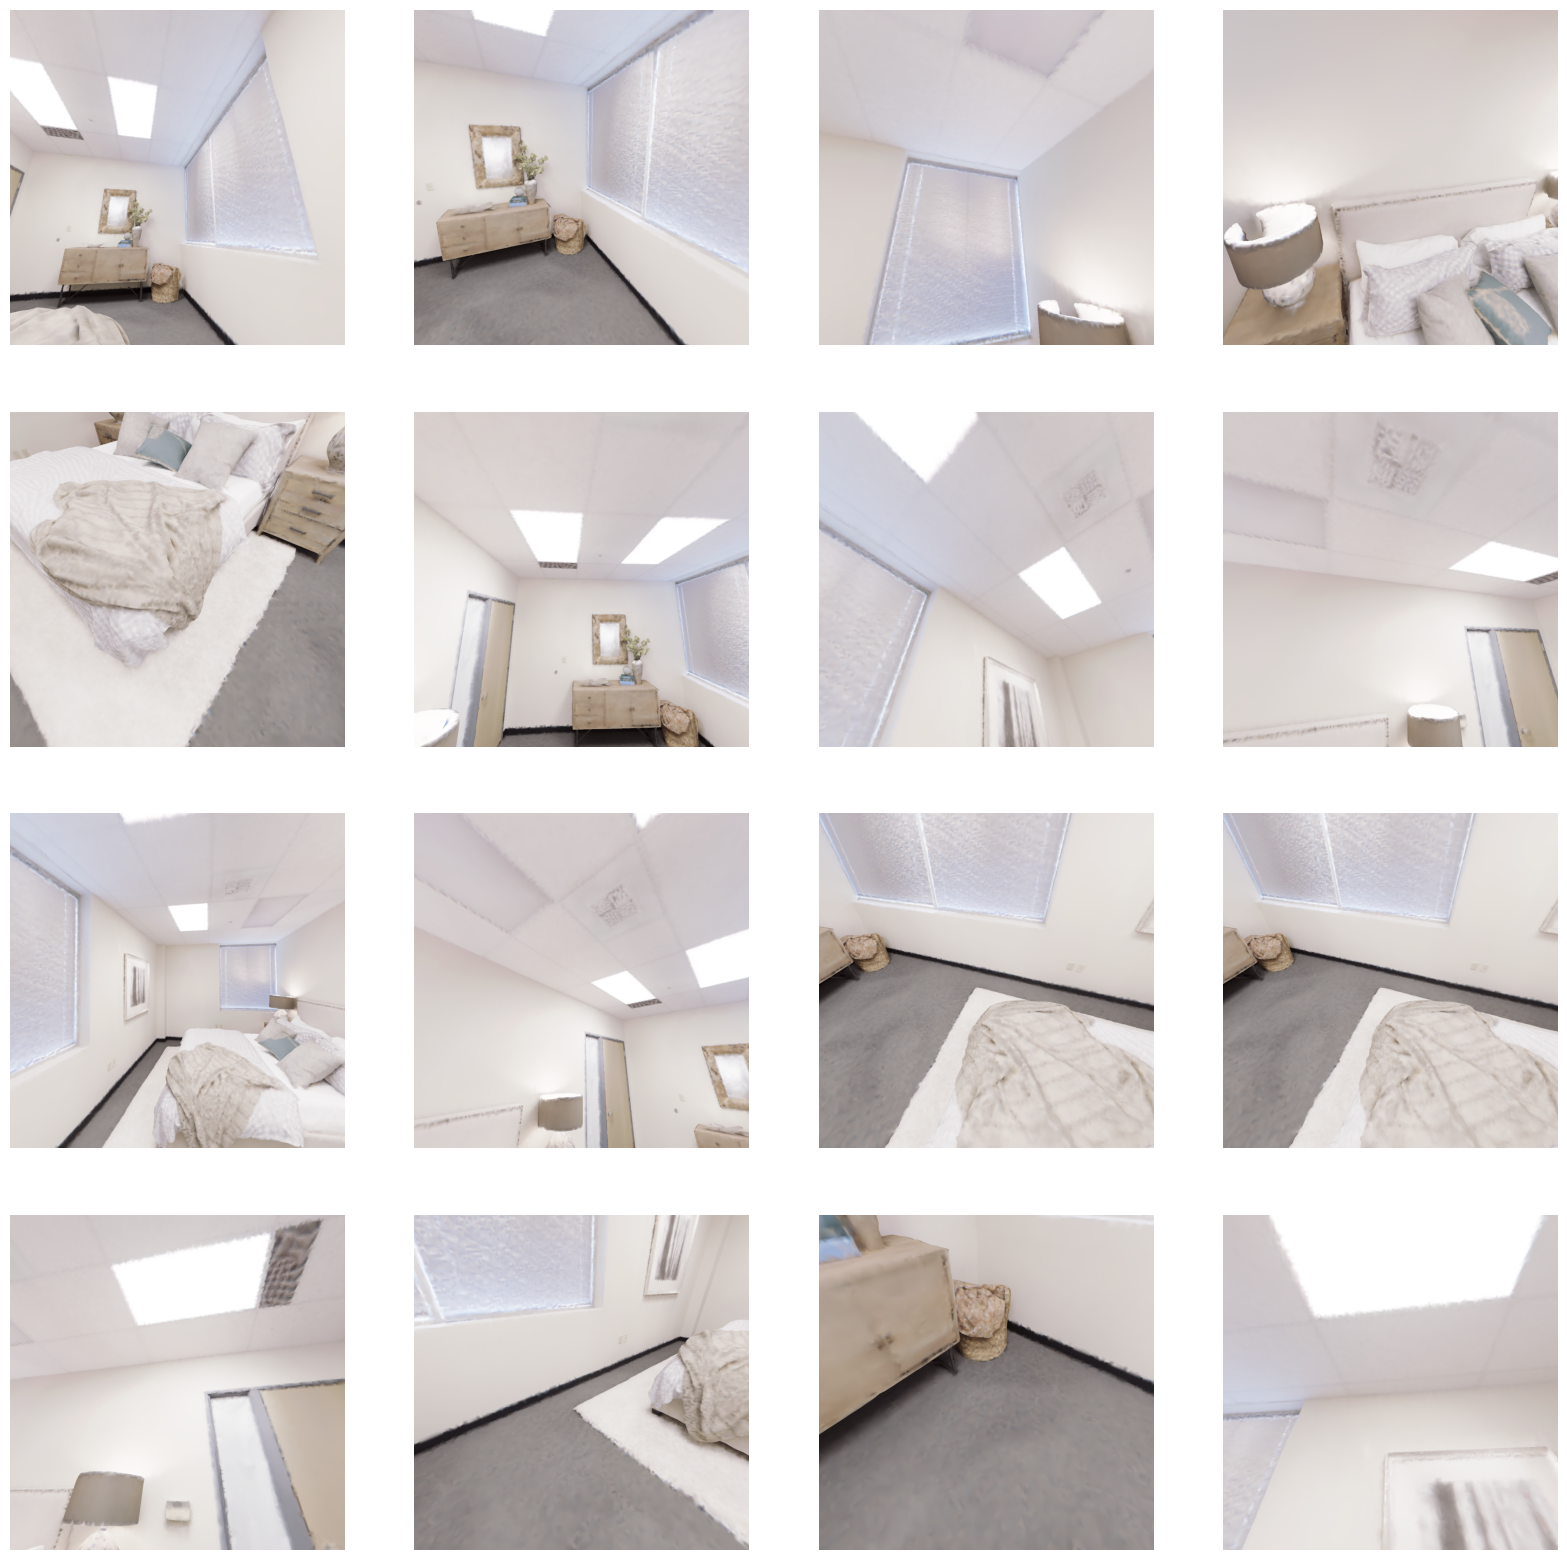

In [65]:
images, tri_ids = [], []

for i in range(0, N, 10):
    images_i, tri_ids_i = ts.render_mesh(
        glctx, mesh, Tw2v=Tw2vs[i:i + 10], image_size=image_size, fovy=math.radians(90))
    images.append(images_i.cpu())
    tri_ids.append(tri_ids_i.cpu())
images, tri_ids = torch.cat(images), torch.cat(tri_ids)
print(utils.show_shape(images, tri_ids))
plt.figure(figsize=(20, 20))
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    # plt.imshow(images[i].cpu().numpy())
    plt.imshow(images[np.random.randint(0, len(images))].cpu().numpy())
    plt.axis('off')

# 2D Segmentation

In [66]:
print(utils.get_GPU_memory())
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
predictor = ts.TreePredictor(model)
print(utils.get_GPU_memory())

(7.401199817657471, 31.7391357421875)
(1.4076781272888184, 31.7391357421875)


image: F32Tensor[1024, 1024, 3]
(7.960776329040527, 31.7391357421875)
(1.4340481758117676, 31.7391357421875)


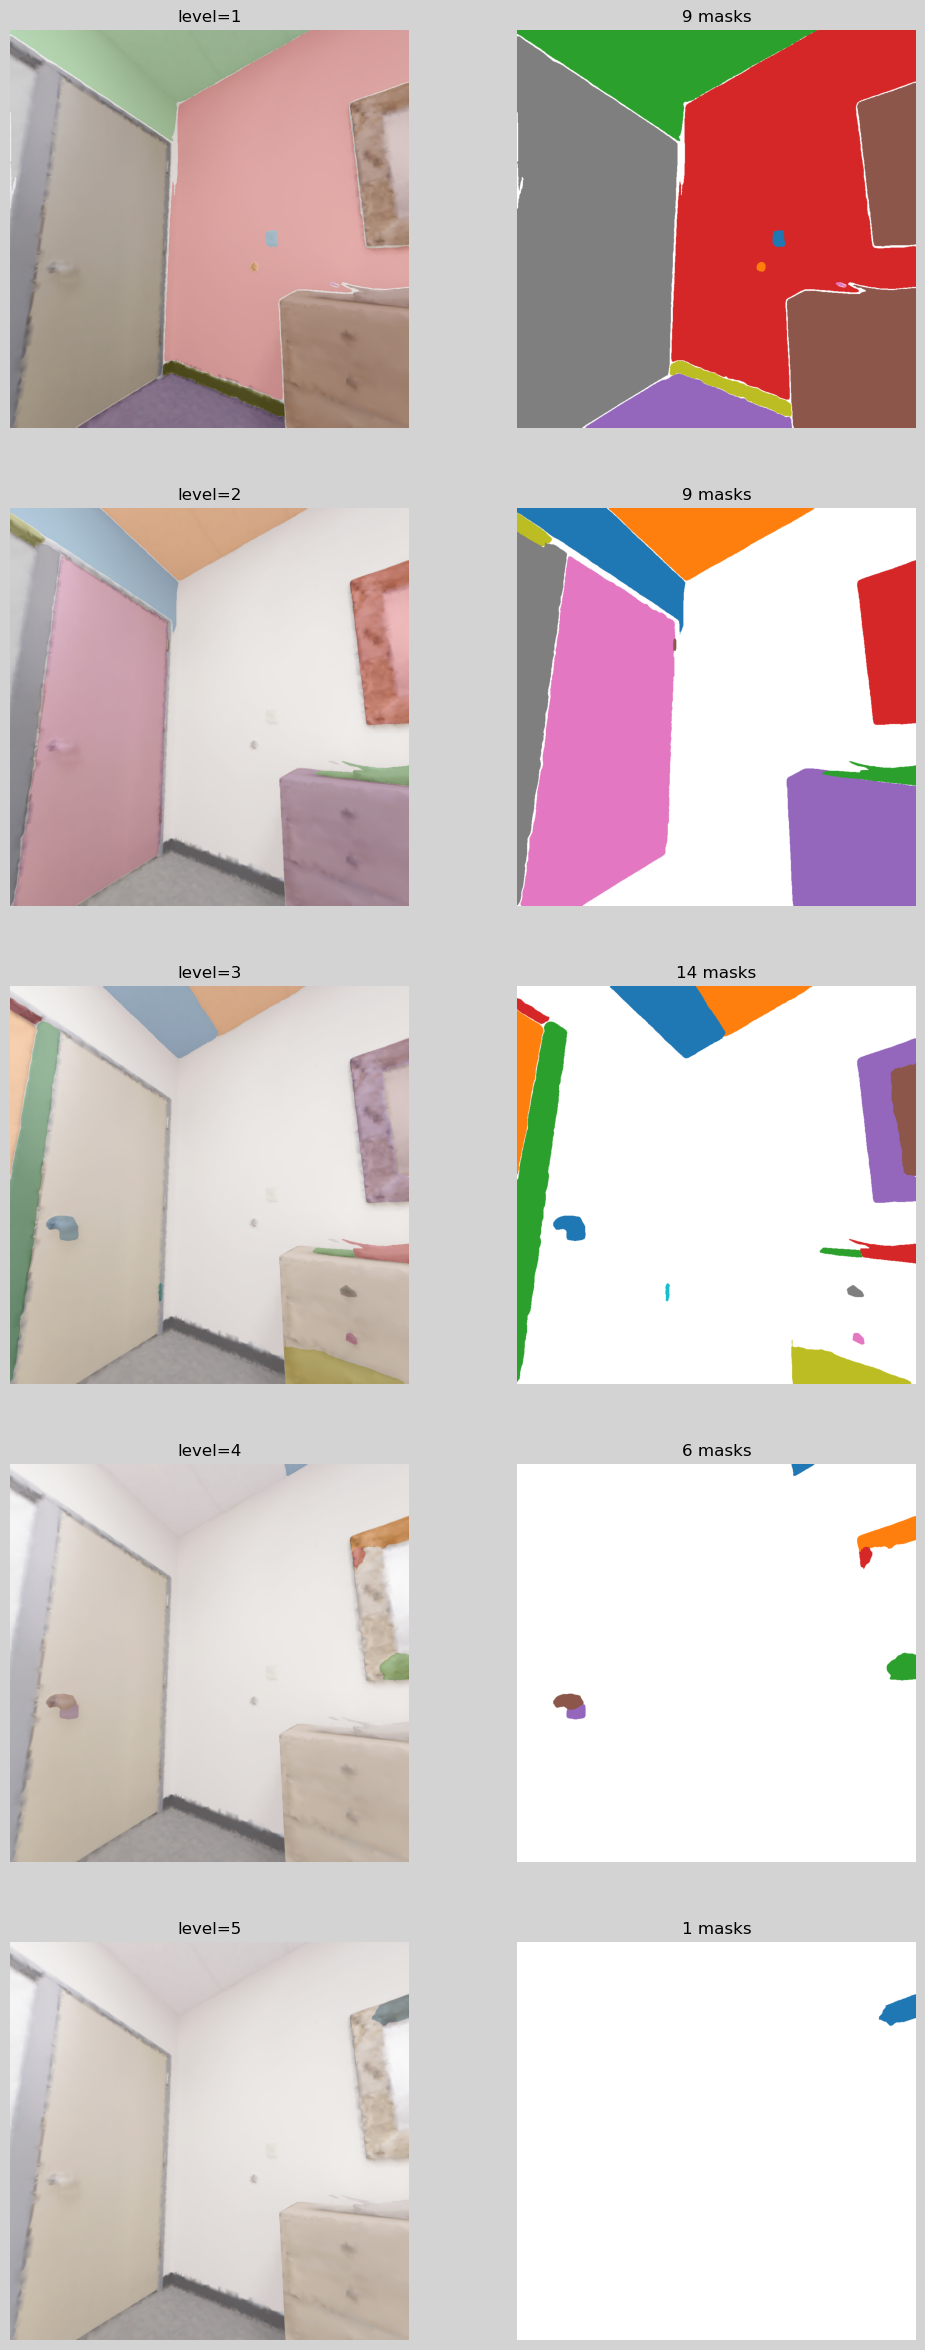

In [67]:
show_index = 0
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.tree_generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_steps=100,
    in_threshold=0.8,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
ts.show_all_levels(image, tree_data, facecolor='lightgray', width=6)
print(utils.get_GPU_memory())
del tree_data
torch.cuda.empty_cache()
print(utils.get_GPU_memory())

In [68]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(N)):
    if 0 and cache_dir.joinpath(f"view_{index:04d}.data").exists():
        continue
    tree_data = predictor.tree_generate(
        (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
        max_steps=100,
        in_threshold=0.8,
        union_threshold=0.1,
        min_mask_region_area=100,
        points_per_update=256,
        device=device,
        in_thre_area=50,
    )
    data = {
        'tree_data': tree_data.save(filename=None),
        'tri_id': tri_ids[index].clone(),
        # 'image': images[index].clone(),
        'Tw2v': Tw2vs[index].clone(),
    }
    torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [31:36<00:00, 18.97s/it]


# 3D Segmentation

In [69]:
tree3d = Tree3Dv2(mesh, device=device, verbose=1)
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir, pack=True)

[Tree] reset
[Tree3D] GPU: (8.705909729003906, 31.7391357421875)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'parent': IntTensor[35], 'first': IntTensor[35], 'next': IntTensor[35], 'last': IntTensor[35], 'cnt': 34, 'num_samples': IntTensor[35], 'masks': IntTensor[5, 1024, 1024], 'scores': F16Tensor[34], 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] GPU: (1.4135427474975586, 31.7391357421875)
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 500000], (IntTensor[23821], LongTensor[23821])
[Tree3D] loaded 100 views, 4243 masks, max_num: 87
[Tree3D] GPU: (4.932981014251709, 31.7391357421875)


In [70]:
# Gv = tree3d.build_view_graph()
# Gm = tree3d.build_graph(Gv)
A = tree3d.build_all_graph()
X, autoencoder = tree3d.compress_masks(epochs=3000)
print(autoencoder)
print(utils.get_GPU_memory())

[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.711, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.157, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.040, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.035, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.029, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.023, lr=9.328e-04
[Tree3D] X epoch[ 600], loss: recon= 0.021, lr=9.043e-04
[Tree3D] X epoch[ 700], loss: recon= 0.018, lr=8.714e-04
[Tree3D] X epoch[ 800], loss: recon= 0.016, lr=8.343e-04
[Tree3D] X epoch[ 900], loss: recon= 0.016, lr=7.937e-04
[Tree3D] X epoch[1000], loss: recon= 0.013, lr=7.498e-04
[Tree3D] X epoch[1100], loss: recon= 0.013, lr=7.032e-04
[Tree3D] X epoch[1200], loss: recon= 0.012, lr=6.544e-04
[Tree3D] X epoch[1300], loss: recon= 0.012, lr=6.038e-04
[Tree3D] X epoch[1400], loss: recon= 0.010, lr=5.522e-04
[Tree3D] X epoch[1500], loss: recon= 0.010, lr=5.000e-04
[Tree3D] X epoch[1600], loss:

In [71]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').cuda()
print(gnn)
tree3d.run(epochs=5000, K=K, gnn=gnn, A=A * A.ge(0.5), X=X)

now_date = time.strftime("%m-%d_%H:%M:%S", time.localtime(time.time()))
tree3d.save(cache_dir.joinpath(f'my_{now_date}.tree3dv2'))

GCN(256, 174, num_layers=2)
[Tree3D] GPU: (5.852725505828857, 31.7391357421875)
[Tree3D] GPU: (5.838928699493408, 31.7391357421875)
[Tree3D] Epoch 100: loss=1.770720, recon= 0.012, match= 0.786, vm= 0.825, mv= 0.103, tree= 0.015
[Tree3D] Epoch 200: loss=1.610508, recon= 0.011, match= 0.620, vm= 0.711, mv= 0.131, tree= 0.013
[Tree3D] Epoch 300: loss=1.518503, recon= 0.012, match= 0.527, vm= 0.655, mv= 0.146, tree= 0.014
[Tree3D] Epoch 400: loss=1.592698, recon= 0.013, match= 0.478, vm= 0.620, mv= 0.151, tree= 0.013
[Tree3D] Epoch 500: loss=0.735446, recon= 0.012, match= 0.426, vm= 0.572, mv= 0.163, tree= 0.012
[Tree3D] Epoch 600: loss=1.254188, recon= 0.011, match= 0.407, vm= 0.555, mv= 0.159, tree= 0.012
[Tree3D] Epoch 700: loss=1.250162, recon= 0.011, match= 0.383, vm= 0.533, mv= 0.163, tree= 0.011
[Tree3D] Epoch 800: loss=1.240052, recon= 0.012, match= 0.368, vm= 0.522, mv= 0.163, tree= 0.011
[Tree3D] Epoch 900: loss=1.393227, recon= 0.012, match= 0.360, vm= 0.508, mv= 0.154, tree= 0

0: Tree Root
├── 118
│   └── 87
├── 117
├── 113
├── 105
├── 103
├── 102
├── 91
├── 90
├── 85
├── 84
│   ├── 116
│   └── 16
├── 83
├── 80
├── 78
├── 71
├── 70
├── 65
│   ├── 107
│   ├── 101
│   ├── 81
│   │   ├── 54
│   │   ├── 32
│   │   ├── 30
│   │   └── 9
│   │       ├── 43
│   │       └── 2
│   ├── 68
│   ├── 1
│   └── 13
│       ├── 114
│       ├── 109
│       ├── 92
│       │   ├── 119
│       │   ├── 7
│       │   └── 77
│       │       ├── 111
│       │       └── 17
│       ├── 89
│       ├── 60
│       ├── 56
│       ├── 47
│       └── 19
├── 62
├── 61
├── 59
├── 58
├── 57
├── 53
├── 51
│   ├── 110
│   └── 5
├── 50
├── 49
├── 44
├── 40
├── 39
├── 35
├── 28
├── 25
├── 23
├── 21
│   ├── 86
│   ├── 45
│   └── 33
├── 20
├── 14
├── 11
├── 8
├── 6
│   └── 10
├── 4
└── 3
    └── 106

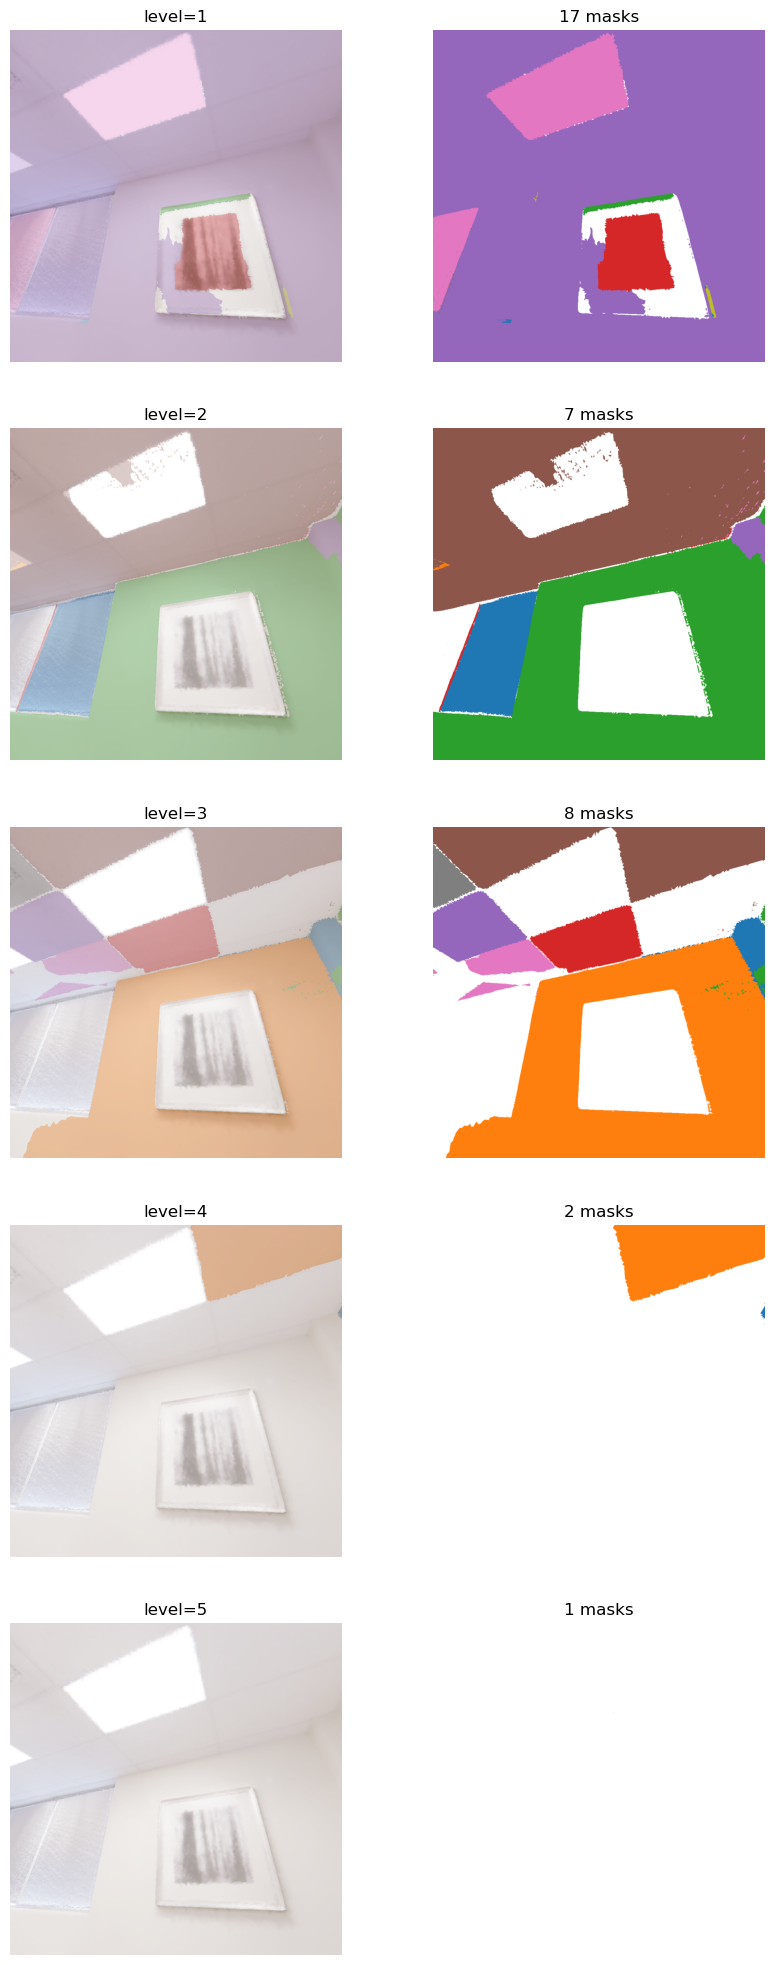

In [73]:
show_index = 8
ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()

In [11]:
print(list(cache_dir.glob('*.tree3dv2')))
tree3d = Tree3Dv2(mesh, device)
tree3d.load(cache_dir.joinpath('my.tree3dv2'))

[PosixPath('results/3d0579debd6956160293c563a88270fd/my.tree3dv2')]
[Tree3D] load results from: results/3d0579debd6956160293c563a88270fd/my.tree3dv2


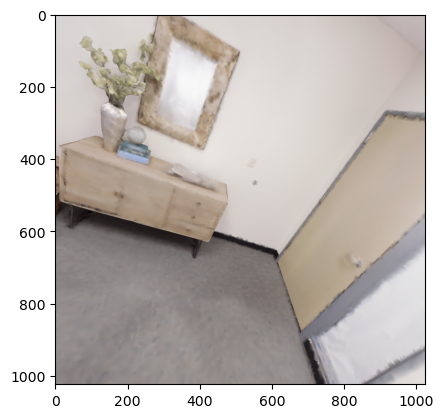

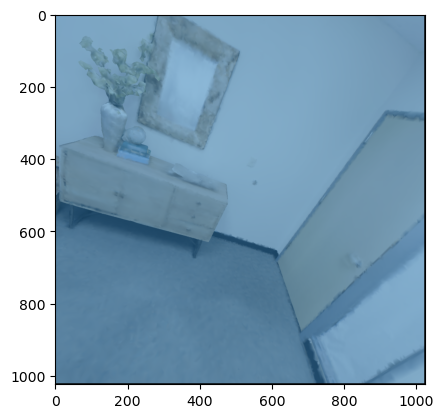

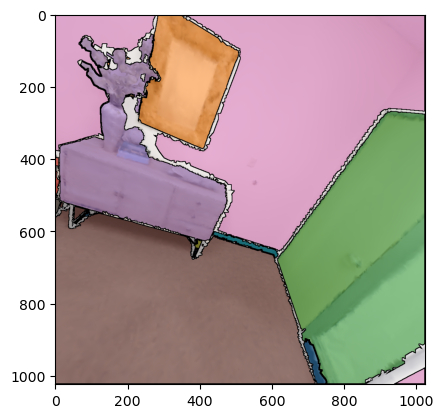

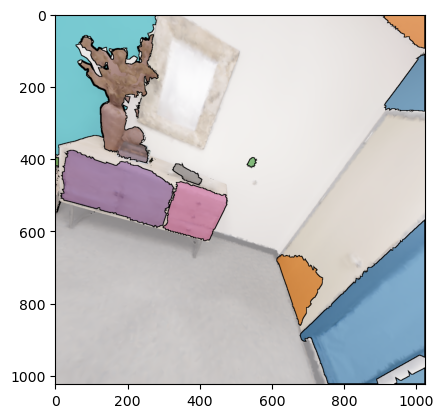

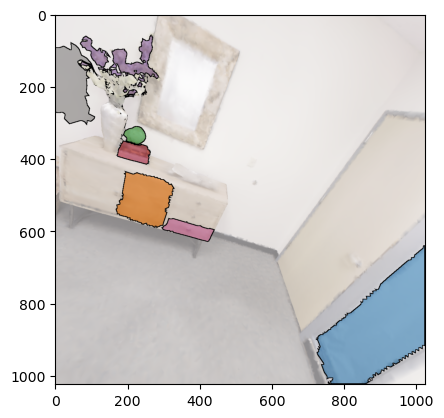

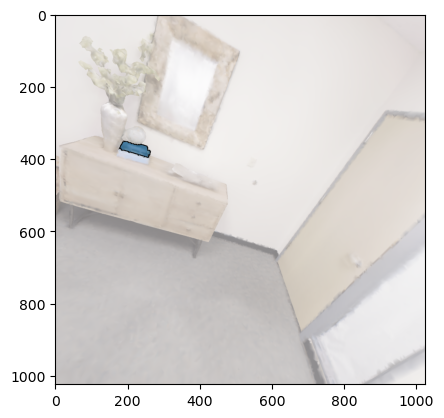

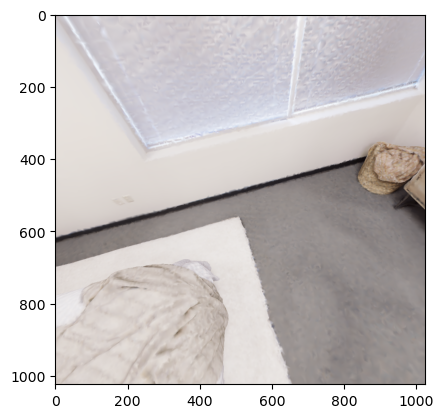

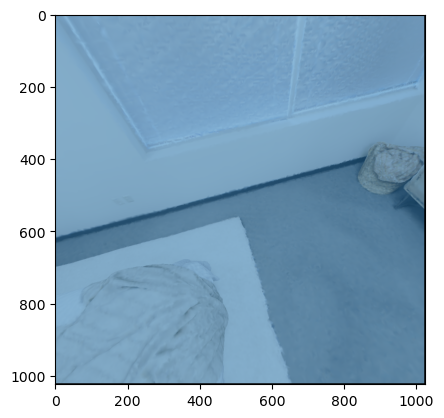

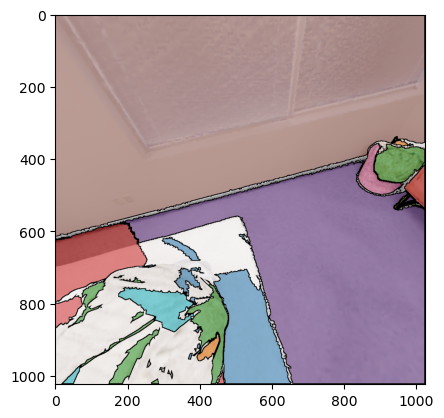

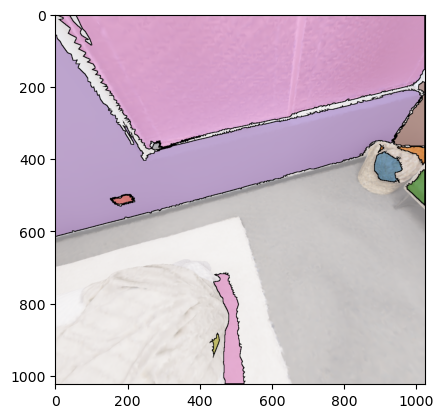

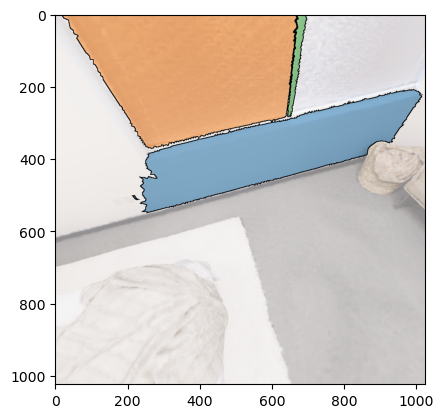

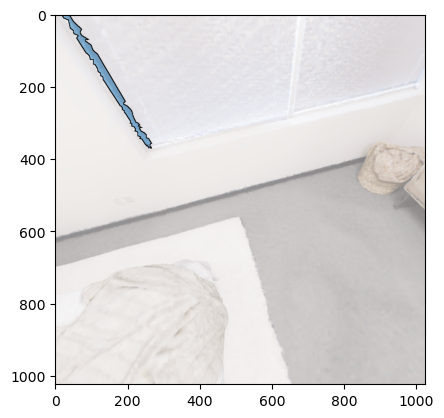

In [ ]:
def save_results(index, save_dir:Path=None, alpha=0.5):
    image = images[index]
    if save_dir is not None:
        save_dir.mkdir(exist_ok=True)
        utils.save_image(save_dir.joinpath(f'view_{index}.png'), image)
    plt.imshow(image.cpu().numpy())
    plt.show()
    # return
  
    tree2d = get_2d_tree_from_3d(tree3d, tri_ids[index].to(device))    
    image = image.cpu().numpy()
    for level, nodes in enumerate( tree2d.get_levels()):
        if level == 0:
            continue
        image_l = image.copy()
        colored_mask = ts.get_colored_masks(tree2d.masks[nodes-1])
        image_l = cv2.addWeighted(image_l, alpha, colored_mask, 1-alpha, 0)
        for x in nodes:
            p = tree2d.parent[x].item() - 1
            x = x.item() - 1
            image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[x], color=(0, 0, 0), kernel_size=5)
            # image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[p],color=(0, 0, 0),  kernel_size=9)
        if save_dir is not None:
            utils.save_image(save_dir.joinpath(f'view_{index}_l{level}.png'), image_l)
        plt.imshow(image_l)
        plt.show()


# for i in range(22):
save_results(8, cache_dir.joinpath('08_11'))
save_results(9)